# Diffusion maps for single-cell data analysis

This notebook serves as a template for the tasks regarding nonlinear dimensionality reduction (chapter 6).

In [43]:
%matplotlib inline
import time
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse.linalg import eigs
from scipy.io import loadmat 
from pandas import read_excel
from math import ceil
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

## Introduction

#### Task 6.1: Implement the diffusion maps algorithm

It is recommended to solve this task by defining a class for diffusion maps and implementing a fit_transform function, which returns the embedding of a given data set. This standardizes the code when comparing diffusion maps with other dimensionality reduction methods from sklearn.

You might want to use scipy.spatial.distance.pdist and scipy.spatial.distance.squareform to efficiently create the Gaussian kernel matrix K.
scipy.sparse.linalg.eigs can compute the eigenvalues of P for you. Don't forget to sort them accordingly and cut away possible imagninary parts (they are zero in theory, but numerically there might be small imagninary values present.)


In [94]:
# your code goes here
from scipy.spatial.distance import sqeuclidean
def gaussian_kernel( X, sigma ):
     K = squareform( pdist( X, lambda u, v: np.exp( -sqeuclidean( u, v ) / ( 2 * sigma * sigma ) ) ) )
     return K

class diffusion_map():
    def __init__( self,eucl_dim ):
        self.map=np.zeros( eucl_dim )
          
    
    
    def fit_transforms(self, X, alpha, s, kernel ):
        K=kernel(X)
        q = np.sum( K, axis=1 )
        q_minus_alpha = np.power( q, -alpha )
        Q_minus_alpha = np.diag( q_minus_alpha )
        K_alpha = np.matmul( Q_minus_alpha, np.matmul( K, Q_minus_alpha ) )
        np.fill_diagonal( K_alpha, 0 )
        D_alpha=np.sum( K_alpha, axis=1 )
        D = np.reciprocal( D_alpha )
        P=np.matmul( np.diag( D ), K_alpha )
        uncleaned_eigenvalues,uncleaned_eigenvectors=eigs(P,s+1,which='LM')
        eigenvalues,eigenvectors=np.real_if_close(uncleaned_eigenvalues,tol=1000),np.real_if_close(uncleaned_eigenvectors,tol=1000)
        idx=np.argsort(eigenvalues)[::-1]
        eigenvalues=eigenvalues[idx]
        eigenvectors=eigenvectors[:,idx]
        eigenvalues=eigenvalues[1:]
        eigenvectors=eigenvectors[:,1:]
        Y = np.matmul(  eigenvectors,np.diag( eigenvalues ) )
        return Y
    

#### Task 6.2: Perform a diffusion map analysis on the Buettner data set. 

After creating a suitable Dataset class we load in the data for tasks 6.2 and 6.3.

In [50]:
class Dataset:
    """
    Data class for simplification for later tasks
    
    Parameters
    ----------
    data: input data [n_cells, n_genes]
    stage_names: names of the cell embryonic stages (time points)
    labels:  assignment of each sample to a cell stage
    num_groups: number of cell stages
    """

    def __init__(self, data, stage_names, labels):
        self.data = data
        self.stage_names = stage_names
        self.labels = labels
        self.num_stages = max(labels)+1

In [51]:
def load_buettner_data(): 
    # load data for task 6.2
    file = loadmat('data//data1.mat')
    data = file.get('in_X')
    data = np.array(data)

    labels = file.get('true_labs')
    labels = labels[:,0] -1

    stage_names = ['1', '2', '3']

    adata = Dataset(data, stage_names, labels)
    return adata

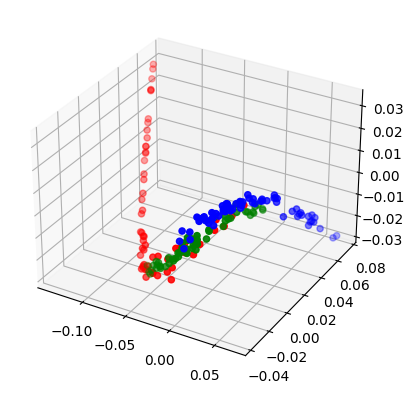

In [111]:
# Run Diffusion Maps on the data set and visualize the results
# your code goes here
adata=load_buettner_data()
dif_map=diffusion_map(3)
transformed_adata=dif_map.fit_transforms(adata.data,1,3, lambda X:gaussian_kernel( X, 20))
#print(transformed_adata)

fig=plt.figure()
ax=plt.axes(projection="3d")
ax.scatter3D(transformed_adata[:59,0],transformed_adata[:59,1],transformed_adata[:59,2], color='red')
ax.scatter3D(transformed_adata[59:117,0],transformed_adata[59:117,1],transformed_adata[59:117,2], color='green')
ax.scatter3D(transformed_adata[117:,0],transformed_adata[117:,1],transformed_adata[117:,2], color='blue')
#ax.set_xlabel('first eigenvector')
#ax.set_ylabel('second eigenvector')
#ax.set_zlabel('third eigenvector')
plt.show()

#### Task 6.3: Perform a PCA analysis of the data set.

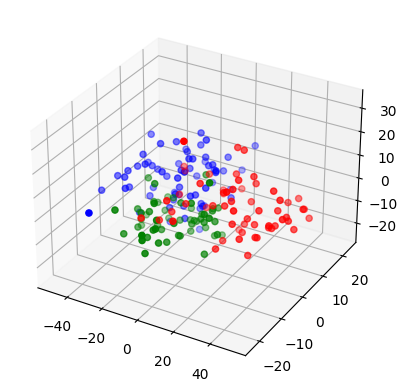

In [113]:
# your code goes here
pdata=PCA(n_components=3).fit_transform(adata.data)


fig=plt.figure()
ax=plt.axes(projection="3d")

ax.scatter3D(pdata[:59,0],pdata[:59,1],pdata[:59,2], color='red')
ax.scatter3D(pdata[59:117,0],pdata[59:117,1],pdata[59:117,2], color='green')
ax.scatter3D(pdata[117:,0],pdata[117:,1],pdata[117:,2], color='blue')
plt.show()


The PCA is much more affected by noise than the diffusion maps analysis and thus gives a worse result. In comparison, the diffusion maps embedding shows a clear structure of the data set. In particular, it reveals relations between the different groups. 

## Single-cell data analysis

In the following, we will apply Diffusion maps to the Guo data. To this end, we first load the data set. To make yourself familiar with the data set it makes sense to look at the _guo.xlsx_ file in the data directory. There, you will find some necessary information:

1. the input data, which is a matrix with a certain number of cells as row number and a certain number of genes as column number,
2. the names of the measured genes and
3. an assignment of each cell to an embryonic stage. These assignments have to be converted into numerical labels to use them for the scatter plots.

### Pre-processing
#### Task 6.4: Pre-process the Guo data.

Take a look at the file guo.xlsx. The naming annotation in the first column refers to the embryonic stage, embryo number, and individual cell number. For example, 64C 2.7 refers to the 7th cell harvested from the 2nd embryo collected from the 64-cell stage. In the first row, you will find the names of the measured genes.
In the following code, the data is cleaned and normalized according to the description in Section 6.4.2.


In [131]:
def load_guo_data():
    # load guo data
    data_frame = read_excel('data//guo.xlsx', sheet_name='Sheet1')

    # data
    adata = data_frame.to_numpy()
    data = adata[:,1:]
    embryonic_stages = adata[:,0]

    # genes
    genes_tmp = data_frame.axes[1][1:]
    genes_names = [genes_tmp[k] for k in range(genes_tmp.size)]
    
    
    # your code goes here
    # Remove 1-cell stage cells
    adata=adata[9:]
    print(adata)
    # Remove cells with values bigger than 28 
    
    # Normalization
    maximum=-256
    for cell in adata:
        x=(cell[1]+cell[16])/2
        for i in range(48):
            if cell[i]!=28:
                cell[i+1]=cell[i+1]-x
                if cell[i+1]>maximum:
                    maximum=cell[i+1]
    # Treat background expression values
    maximum=np.ceil(maximum)
    for cell in adata:
        for i in range(48):
            if cell[i]==28:
                cell[i]=maximum
    # Round
    np.round(adata,3)
    
    
    
    
    # stage_names and creating labels
    stage_names = ['2C', '4C', '8C', '16C', '32C', '64C']

    labels = np.array([next(np.where([name.startswith(sname) for name in stage_names])[0][0] 
        for sname in stage_names if ename.startswith(sname)) for ename in embryonic_stages])

    adata = Dataset(data, stage_names, labels)
    return adata

#### Task 6.5: Perform a Diffusion map analysis of the pre-processed Guo data.

In [132]:
# your code goes here
load_guo_data()






[['2C 1.1' 15.64 28.0 ... 28.0 28.0 19.31]
 ['2C 1.2' 16.08 23.68 ... 28.0 23.7 20.99]
 ['2C 2.1' 15.84 24.16 ... 28.0 28.0 21.15]
 ...
 ['64C 7.12' 12.75 22.73 ... 28.0 28.0 17.73]
 ['64C 7.13' 13.66 25.26 ... 28.0 28.0 18.87]
 ['64C 7.14' 13.78 25.46 ... 28.0 28.0 18.47]]


TypeError: '>' not supported between instances of 'str' and 'int'

#### Task 6.6: Comparison with the un-pre-processed data.
Now we just remove cells with values bigger than 28 and round the original data. Thus, we skip the cleaning and normaliztation part.

In [ ]:
# your code goes here
# load guo data
data_frame = read_excel('data//guo.xlsx', sheet_name='Sheet1')

# data
adata = data_frame.to_numpy()
data = adata[:,1:]
embryonic_stages = adata[:,0]

# genes
genes_tmp = data_frame.axes[1][1:]
genes_names = [genes_tmp[k] for k in range(genes_tmp.size)]

# your code goes here
# Remove cells with values bigger than 28  


# Round




# stage_names and creating labels
stage_names = ['1C', '2C', '4C', '8C', '16C', '32C', '64C']

labels = np.array([next(np.where([name.startswith(sname) for name in stage_names])[0][0] 
    for sname in stage_names if ename.startswith(sname)) for ename in embryonic_stages])

adata = Dataset(data, stage_names,labels)


# Run diffusion maps and visualize the results
# your code goes here


The non-pre-processed Guo data is less appropriate for analysis. In particular, the 1-cell stage cells deliver a distorted picture. The branching of the PE and EPI lineages cannot be detected here.

### Comparison with other dimensionality reduction methods

#### Task 6.7: Compare Diffusion maps with PCA and tSNE.

In [ ]:
# your code goes here





### Parameter selection

#### Task 6.8: Bandwidth comparison
We run Diffusion Maps with different bandwidth parameters sigma.

In [ ]:
# your code goes here






#### Task 6.9: Implement the Lafon rule for $\sigma$ and plot the embedding with the $\sigma$ chosen by this rule.

In [ ]:
# your code goes here





### Cell group detection

Now, we want to apply spectral clustering to detect cell groups in the single-cell data.

#### Task 6.10: Implement the spectral clustering algorithm using k-means with k as input.

In [ ]:
# your code goes here




#### Task 6.11: Plot the first 20 eigenvalues of transition matrix $P$ for the Guo data and identify k.

In [ ]:
# your code goes here





#### Task 6.12: Perform the spectral clustering algorithm for the Guo data.

In [ ]:
# your code goes here



